## Import Data

In [2]:
import os
import numpy as np
import pandas as pd
import csv
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem import rdMolDescriptors as rd
from eosce.models import ErsiliaCompoundEmbeddings
import torch as th
import torch.nn.functional as fn


df = pd.read_csv('data/smiles_embeddings_all.csv')
df.head()

,Unnamed: 0,DrugBankID,SMILES,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,...,embedding_390,embedding_391,embedding_392,embedding_393,embedding_394,embedding_395,embedding_396,embedding_397,embedding_398,embedding_399
0,0,Compound::DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,-0.659347,-0.344230,-0.578348,-0.670077,0.073021,-0.844866,-0.529099,...,0.722160,-0.361777,-0.069529,0.719951,0.765324,-0.828312,-0.750704,-0.360401,-0.359896,-0.820253
1,1,Compound::DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,-0.606968,-0.781302,-0.730112,-0.868258,0.363371,-0.388290,0.217138,...,-0.355017,0.657896,0.039386,-0.395858,-0.218164,-0.540272,-0.603087,-0.853275,0.545669,-0.836144
2,2,Compound::DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,-0.470256,-0.885203,-0.623956,-0.507102,0.395201,-0.298908,-0.156826,...,-0.430036,0.563329,0.419391,-0.074537,0.266462,-0.631508,-0.637233,-0.816603,0.416263,-0.720862
3,3,Compound::DB00027,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,-0.761337,-0.709398,0.665223,-0.388625,0.218644,-0.416196,0.594226,...,-0.721291,0.630432,0.817134,0.515158,-0.247925,-0.523338,-0.827212,-0.751571,-0.640211,-0.756264
4,4,Compound::DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,-0.764784,-0.956786,-0.445434,-0.611626,0.335249,0.044306,-0.635370,...,-0.204678,-0.404126,-0.018485,-0.401169,0.025806,-0.664728,-0.856459,-0.417736,-0.386456,-0.626406


In [3]:
df.shape

(8807, 403)

In [3]:
# Drop the untitled column
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.head()

,DrugBankID,SMILES,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_390,embedding_391,embedding_392,embedding_393,embedding_394,embedding_395,embedding_396,embedding_397,embedding_398,embedding_399
0,Compound::DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,-0.659347,-0.344230,-0.578348,-0.670077,0.073021,-0.844866,-0.529099,-0.797582,...,0.722160,-0.361777,-0.069529,0.719951,0.765324,-0.828312,-0.750704,-0.360401,-0.359896,-0.820253
1,Compound::DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,-0.606968,-0.781302,-0.730112,-0.868258,0.363371,-0.388290,0.217138,-0.640213,...,-0.355017,0.657896,0.039386,-0.395858,-0.218164,-0.540272,-0.603087,-0.853275,0.545669,-0.836144
2,Compound::DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,-0.470256,-0.885203,-0.623956,-0.507102,0.395201,-0.298908,-0.156826,-0.697836,...,-0.430036,0.563329,0.419391,-0.074537,0.266462,-0.631508,-0.637233,-0.816603,0.416263,-0.720862
3,Compound::DB00027,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,-0.761337,-0.709398,0.665223,-0.388625,0.218644,-0.416196,0.594226,-0.497919,...,-0.721291,0.630432,0.817134,0.515158,-0.247925,-0.523338,-0.827212,-0.751571,-0.640211,-0.756264
4,Compound::DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,-0.764784,-0.956786,-0.445434,-0.611626,0.335249,0.044306,-0.635370,-0.706563,...,-0.204678,-0.404126,-0.018485,-0.401169,0.025806,-0.664728,-0.856459,-0.417736,-0.386456,-0.626406


## Split data into train and test set 
Store the data as a CSV file.

In [5]:
# Split the DataFrame into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Save the train and test sets to CSV files
# train_df.to_csv('data/train.csv', index=False)
# test_df.to_csv('data/test.csv', index=False)

## Ersilia Descriptor Model

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
# Function to calculate Ersilia descriptors
def calculate_ersilia_descriptors(smiles):
    model = ErsiliaCompoundEmbeddings()
    embeddings = model.transform([smiles])
    return embeddings

# Function to preprocess data and create embeddings
def preprocess_data(df):
    # Get the target embeddings
    embeddings = df.iloc[:, 2:].values
    # create Ersilia descriptor columns
    df['ersilia_descriptors'] = df['SMILES'].apply(calculate_ersilia_descriptors)
    df = df.dropna()
    # Extract the descriptors as a NumPy array
    ersilia_descriptors = np.vstack(df['ersilia_descriptors'].values)
    return ersilia_descriptors, embeddings

In [6]:
# The ersilia descriptor is X, our features
# The embeddings is y, our target variable
X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

print("The length of X_train is:", len(X_train))
print("The length of X_test is:", len(X_test))

[19:03:09] Unusual charge on atom 0 number of radical electrons set to zero


The length of X_train is: 7045
The length of X_test is: 1762


In [8]:
print(X_train.shape)
print(X_train)

(7045, 1024)
[[-0.02297795 -0.04393283 -0.00267219 ... -0.00575614 -0.08817158
   0.0451123 ]
 [ 0.01728612 -0.01224638 -0.06066136 ... -0.01870611 -0.05308999
  -0.02502198]
 [ 0.14361586  0.1458011  -0.1337858  ... -0.0482729   0.01063045
  -0.10152555]
 ...
 [ 0.27700824  0.19359195 -0.22861645 ... -0.02889996 -0.01134796
  -0.08853202]
 [-0.00341973  0.03548691  0.10431875 ... -0.01475573  0.01532023
   0.04705036]
 [ 0.12424359 -0.15632716 -0.07696831 ...  0.03071315 -0.12634373
   0.03119451]]


## Train Model with Keras Tuner

In [13]:
TUNER_PROJECT_NAME_A = "tuner_trials"


class TunerRegressorAutoTrainer(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.input_shape = X.shape[1]
        self.output_shape = y.shape[1]

    def _model_builder(self, hp):
        model = keras.Sequential()
        hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
        model.add(
            keras.layers.Dense(
                units=hp_units,
                activation="relu", input_shape=(self.input_shape,)
            )
        )
        for i in range(hp.Int('layers', 1, 6)):
            model.add(
                keras.layers.Dense(
                    units=hp.Int("units_"+str(i), min_value=32, max_value=512, step=32),
                    activation="relu"
                )
            )
        model.add(keras.layers.Dense(self.output_shape))
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss="mean_squared_error",
            metrics=None,
        )

        return model

    def _search(self, X, y):
        self.tuner = kt.Hyperband(
            self._model_builder,
            objective="val_loss",
            max_epochs=10,
            factor=3,
            directory=TUNER_PROJECT_NAME_A,
            project_name="trials",
        )
        stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
        self.tuner.search(
            X, y, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=True
        )
        self.best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]

    def _get_best_epoch(self, X, y):
        # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(X, y, epochs=50, validation_split=0.2)

        val_per_epoch = history.history["val_loss"]
        self.best_epoch = val_per_epoch.index(min(val_per_epoch)) + 1
        print("Best epoch: %d" % (self.best_epoch,))

    def _final_train(self, X, y):
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)

        # Retrain the model
        self.hypermodel.fit(X, y, epochs=self.best_epoch, validation_split=0.2)

    def fit(self):
        self._search(self.X, self.y)
        self._get_best_epoch(self.X, self.y)
        self._final_train(self.X, self.y)
        self.hypermodel.save(os.path.join(TUNER_PROJECT_NAME_A, "ersilia_model"))

    def export_model(self):
        return self.hypermodel

In [14]:
# Instantiate the model
trainer = TunerRegressorAutoTrainer(X_train, y_train)
# Train model
trainer.fit()

Reloading Tuner from tuner_trials/trials/tuner0.json
Epoch 1/50
177/177 [==============================] - 7s 32ms/step - loss: 0.2398 - val_loss: 0.2335
Epoch 2/50
177/177 [==============================] - 5s 31ms/step - loss: 0.2281 - val_loss: 0.2299
Epoch 3/50
177/177 [==============================] - 6s 32ms/step - loss: 0.2215 - val_loss: 0.2286
Epoch 4/50
177/177 [==============================] - 6s 32ms/step - loss: 0.2154 - val_loss: 0.2286
Epoch 5/50
177/177 [==============================] - 6s 33ms/step - loss: 0.2089 - val_loss: 0.2280
Epoch 6/50
177/177 [==============================] - 6s 31ms/step - loss: 0.2031 - val_loss: 0.2299
Epoch 7/50
177/177 [==============================] - 6s 31ms/step - loss: 0.1976 - val_loss: 0.2286
Epoch 8/50
177/177 [==============================] - 6s 32ms/step - loss: 0.1922 - val_loss: 0.2289
Epoch 9/50
177/177 [==============================] - 6s 31ms/step - loss: 0.1864 - val_loss: 0.2320
Epoch 10/50
177/177 [=================

INFO:tensorflow:Assets written to: tuner_trials/ersilia_model/assets


In [15]:
# # save the best model
model = trainer.export_model()

In [9]:
# load the saved model
model = keras.models.load_model("tuner_trials/ersilia_model")

# predict the embeddings of the drug ersilia descriptor
ersilia_embeddings = model.predict(X_test)
train_ersilia_embeddings = model.predict(X_train)
print(ersilia_embeddings)

  5/221 [..............................] - ETA: 2s 

2023-12-21 19:29:27.673274: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28856320 exceeds 10% of free system memory.


221/221 [==============================] - 1s 7ms/step
[[ 0.08472562  0.37838006 -0.19955418 ... -0.0180915   0.1547238
   0.16554165]
 [ 0.16847338  0.41126248 -0.25568983 ...  0.13332686 -0.08615044
   0.17281902]
 [-0.38090032  0.34923962 -0.03371755 ...  0.03326432  0.16672465
   0.02041129]
 ...
 [ 0.1424219   0.10786689 -0.20136242 ... -0.2616253   0.70327926
  -0.5750887 ]
 [ 0.15442257  0.25557345 -0.14579663 ... -0.03572423  0.18714821
  -0.10769947]
 [ 0.04164761  0.17801479 -0.07485196 ...  0.04903887  0.05003881
  -0.14099663]]


## Evaluate Embeddings

### Column-wise evaluation
Compare the embeddings based on the index (original and predicted) of all the drugs


In [11]:
def col_comparison(embedding_index, original_embeddings=y_test, predicted_embeddings=ersilia_embeddings):
    '''Function to compare the original embeddings with the predicted embeddings.
    It uses a regression plot and Pearson correlation for comparison.
        
    Parameter
    ----------
    embedding_index (int): number specifying the embedding you want to compare. It ranges from 0-399.
    original_embeddings (np.array): The original embeddings from the knowledge graph.
    predicted_embeddingns (np.array): The embeddings predicted by the model
    
    Returns
    -------
    pearson_corr (np.array): person correlation score.
    '''
    # Extract embedding_index for both arrays
    embedding_index_y_test = original_embeddings[:, embedding_index]
    embedding_index_mf = predicted_embeddings[:, embedding_index]

    # Create a DataFrame for Seaborn plotting
    emb_df = pd.DataFrame({'Embedding_index_y_test': embedding_index_y_test,
                       'Embedding_index_mf': embedding_index_mf})

    # Plot the regression plot with Pearson correlation
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Embedding_index_y_test', y='Embedding_index_mf', data=emb_df, scatter_kws={'s': 10})
    plt.title(f'Regression Plot of Embedding_{embedding_index}  for y_test and Ersilia Embeddings')
    plt.xlabel(f'Original Embedding {embedding_index}')
    plt.ylabel(f'Predicted Embedding {embedding_index}')
    plt.show()

    # Calculate the Pearson correlation
    pearson_corr = np.corrcoef(embedding_index_y_test, embedding_index_mf)[0, 1]
    print(f'Pearson Correlation: {pearson_corr:.4f}')

#### Test Set

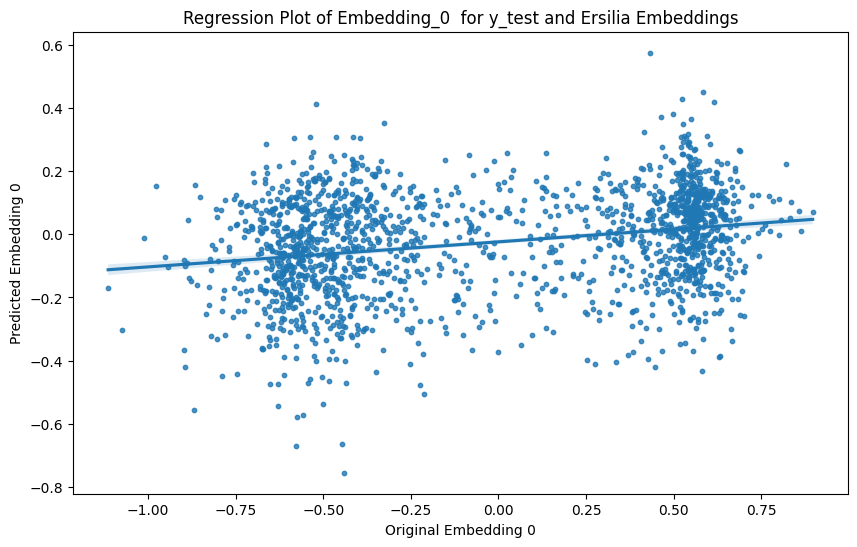

Pearson Correlation: 0.2521


In [12]:
col_comparison(0)

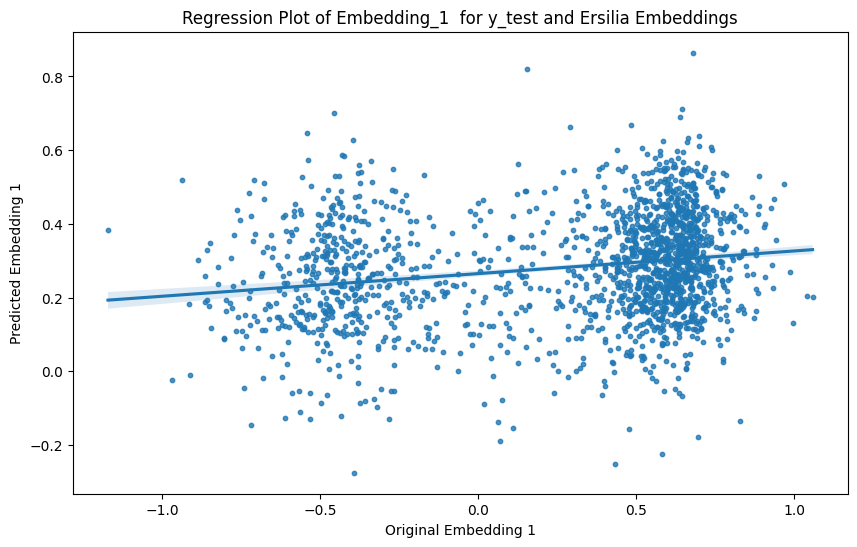

Pearson Correlation: 0.2024


In [13]:
col_comparison(1)

#### Train Set

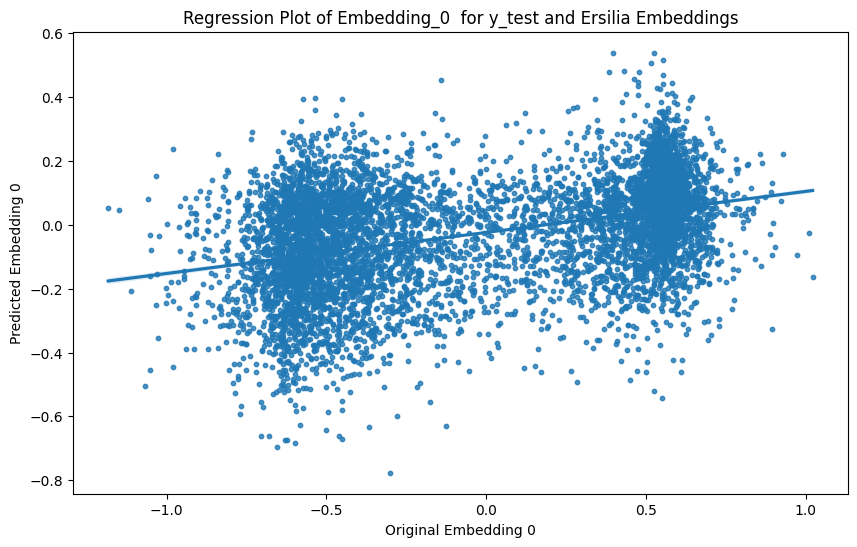

Pearson Correlation: 0.3853


In [14]:
col_comparison(0, 
               original_embeddings=y_train, 
               predicted_embeddings=train_ersilia_embeddings)

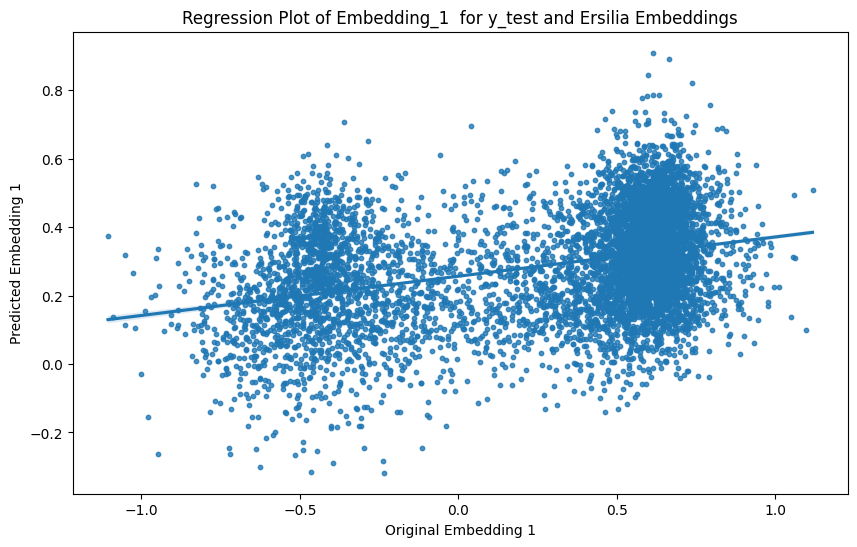

Pearson Correlation: 0.3467


In [16]:
col_comparison(1, 
               original_embeddings=y_train, 
               predicted_embeddings=train_ersilia_embeddings)

### Row-wise Comparison of Embeddings
Compare the 400 embeddings (original and predicted) of a particular drug

In [19]:
def row_comparison(drug_index, original_embeddings=y_test, predicted_embeddings=ersilia_embeddings):
    '''Function to compare the 400 original embeddings with the predicted embeddings for a drug
    It uses a regression plot and Pearson correlation for comparison.
        
    Parameter
    ----------
    drug_index (int): number specifying the drug embedding you want to compare. It ranges from 0-1761.
    original_embeddings (np.array): The original embeddings from the knowledge graph.
    predicted_embeddingns (np.array): The embeddings predicted by the model
    
    Returns
    -------
    pearson_corr (np.array): person correlation score.
    '''
    # Extract embeddings for the specified drug
    embeddings_y_test = original_embeddings[drug_index]
    embeddings_mf = predicted_embeddings[drug_index]

    # Create a DataFrame for Seaborn plotting
    df = pd.DataFrame({'Embeddings_y_test': embeddings_y_test,
                       'Embeddings_mf': embeddings_mf})

    # Plot the regression plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Embeddings_y_test', y='Embeddings_mf', data=df, scatter_kws={'s': 10})
    plt.title(f'Regression Plot of Embeddings for Drug {drug_index}')
    plt.xlabel(f'Original Embeddings for Drug {drug_index}')
    plt.ylabel(f'Predicted Embeddings for Drug {drug_index}')
    plt.show()

     # Calculate the Pearson correlation
    pearson_corr = np.corrcoef(embeddings_y_test, embeddings_mf)[0, 1]
    print(f'Pearson Correlation: {pearson_corr:.4f}')

#### Test Set

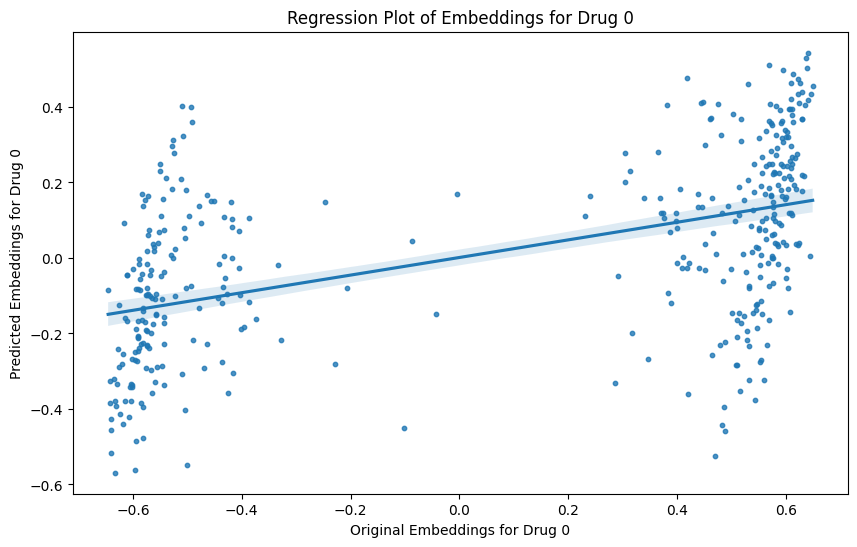

Pearson Correlation: 0.5085


In [20]:
row_comparison(0)

#### Train Set

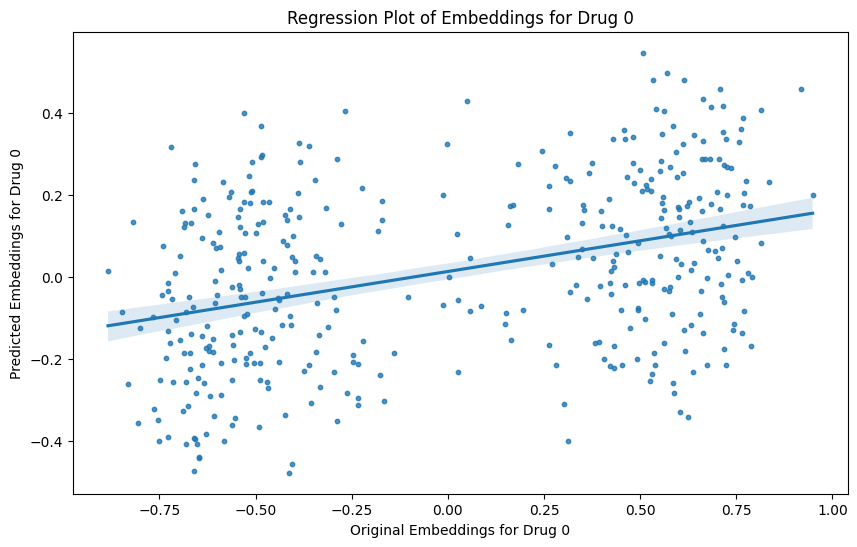

Pearson Correlation: 0.3835


In [21]:
row_comparison(0, 
               original_embeddings=y_train, 
               predicted_embeddings=train_ersilia_embeddings)

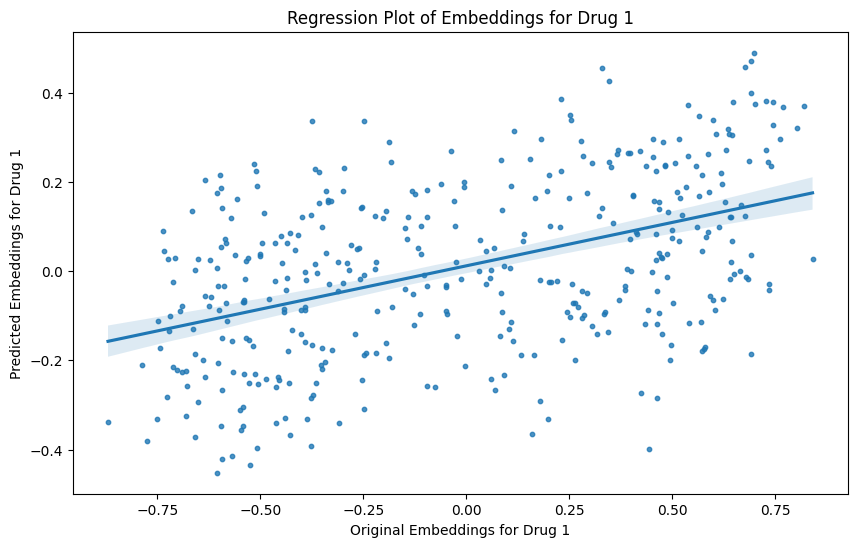

Pearson Correlation: 0.4634


In [22]:
row_comparison(1, 
               original_embeddings=y_train, 
               predicted_embeddings=train_ersilia_embeddings)

## Predict the Edge Score

In [20]:
COV_disease_list = [
'Disease::SARS-CoV2 E',
'Disease::SARS-CoV2 M',
'Disease::SARS-CoV2 N',
'Disease::SARS-CoV2 Spike',
'Disease::SARS-CoV2 nsp1',
'Disease::SARS-CoV2 nsp10',
'Disease::SARS-CoV2 nsp11',
'Disease::SARS-CoV2 nsp12',
'Disease::SARS-CoV2 nsp13',
'Disease::SARS-CoV2 nsp14',
'Disease::SARS-CoV2 nsp15',
'Disease::SARS-CoV2 nsp2',
'Disease::SARS-CoV2 nsp4',
'Disease::SARS-CoV2 nsp5',
'Disease::SARS-CoV2 nsp5_C145A',
'Disease::SARS-CoV2 nsp6',
'Disease::SARS-CoV2 nsp7',
'Disease::SARS-CoV2 nsp8',
'Disease::SARS-CoV2 nsp9',
'Disease::SARS-CoV2 orf10',
'Disease::SARS-CoV2 orf3a',
'Disease::SARS-CoV2 orf3b',
'Disease::SARS-CoV2 orf6',
'Disease::SARS-CoV2 orf7a',
'Disease::SARS-CoV2 orf8',
'Disease::SARS-CoV2 orf9b',
'Disease::SARS-CoV2 orf9c',
'Disease::MESH:D045169',
'Disease::MESH:D045473',
'Disease::MESH:D001351',
'Disease::MESH:D065207',
'Disease::MESH:D028941',
'Disease::MESH:D058957',
'Disease::MESH:D006517'
]

treatment = ['Hetionet::CtD::Compound:Disease','GNBR::T::Compound:Disease']


gamma = 12.0

def transE_l2(head, rel, tail):
    score = head + rel - tail
    return gamma - th.norm(score, p=2, dim=-1)


def edge_score(embeddings):
    '''Function to calculate the edge scores.

    Argument
    ---------
    embeddings (array). Array of size 400 containing 
            the embeddings of the SMILES molecule.

    Returns
    --------
    scores (tensor). Tensor showing the edge score for 
            each disease based on the drug_embeddings, relation_embeddings,
            and COVID_disease embeddings.
    '''
    
    # Load entity and relation mapping files
    entity_idmap_file = '../data/embed/entities.tsv'
    relation_idmap_file = '../data/embed/relations.tsv'

    # Get drugname/disease name to entity ID mappings
    entity_map = {}
    entity_id_map = {}
    relation_map = {}
    
    with open(entity_idmap_file, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name', 'id'])
        for row_val in reader:
            entity_map[row_val['name']] = int(row_val['id'])
            entity_id_map[int(row_val['id'])] = row_val['name']

    with open(relation_idmap_file, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['name', 'id'])
        for row_val in reader:
            relation_map[row_val['name']] = int(row_val['id'])

    # Handle the ID mapping
    # drug_ids = [entity_map[drug] for drug in drug_list]
    disease_ids = [entity_map[disease] for disease in COV_disease_list]
    treatment_rid = [relation_map[treat] for treat in treatment]

    # Load embeddings
    entity_emb = np.load('../data/embed/DRKG_TransE_l2_entity.npy')
    rel_emb = np.load('../data/embed/DRKG_TransE_l2_relation.npy')

    # drug_ids = th.tensor(drug_ids).long()
    disease_ids = th.tensor(disease_ids).long()
    treatment_rid = th.tensor(treatment_rid)

    # Use our model's embeddings here
    drug_emb = th.tensor(embeddings)
    # drug_emb = th.tensor(entity_emb[drug_ids]) # get embeddings from knowledge graph
    
    treatment_embs = [th.tensor(rel_emb[rid]) for rid in treatment_rid]

    scores_per_disease = []
    for rid in range(len(treatment_embs)):
        treatment_emb=treatment_embs[rid]
        for disease_id in disease_ids:
            disease_emb = entity_emb[disease_id]
            score = fn.logsigmoid(transE_l2(drug_emb, treatment_emb, disease_emb))
            scores_per_disease.append(score)
            
    # Convert scores_per_disease to a list of tensors
    scores_tensors = [th.tensor(scores, dtype=th.float32) for scores in scores_per_disease]
    # Get the first combo edge score
    return scores_tensors[0]

    # # Ensure the list of tensors is not empty before calculating the max
    # if scores_tensors:
    #     # Stack the list of tensors along a new dimension (axis 0)
    #     scores_tensor = th.stack(scores_tensors, dim=0)
    #     # Calculate the maximum score for each drug along the existing dimension (axis 0)
    #     max_scores, _ = th.max(scores_tensor, dim=0)
    #     # Print the shape and content of the max_scores tensor
    #     print("Shape of max_scores:", max_scores.shape)
    #     # print("Maximum scores for each drug:", max_scores.tolist())  # Use .tolist() to get a Python list
    #     return max_scores
    # else:
    #     print("The list of tensors is empty.")
    #     return None

In [21]:
# y_test has the original embeddings
# Predict the original_edge_score
original_edge_score = edge_score(y_test)

# Predict the ersilia descriptor edge score
ersilia_edge_score = edge_score(ersilia_embeddings)

/tmp/ipykernel_20370/449694285.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores_tensors = [th.tensor(scores, dtype=th.float32) for scores in scores_per_disease]


In [22]:
ersilia_edge_score

tensor([-3.7193, -3.7239, -3.6109,  ..., -3.5449, -3.4380, -3.4775])

In [23]:
original_edge_score

tensor([-7.0180, -6.4491, -6.4137,  ..., -6.0347, -5.3829, -6.3878])

## Plot result

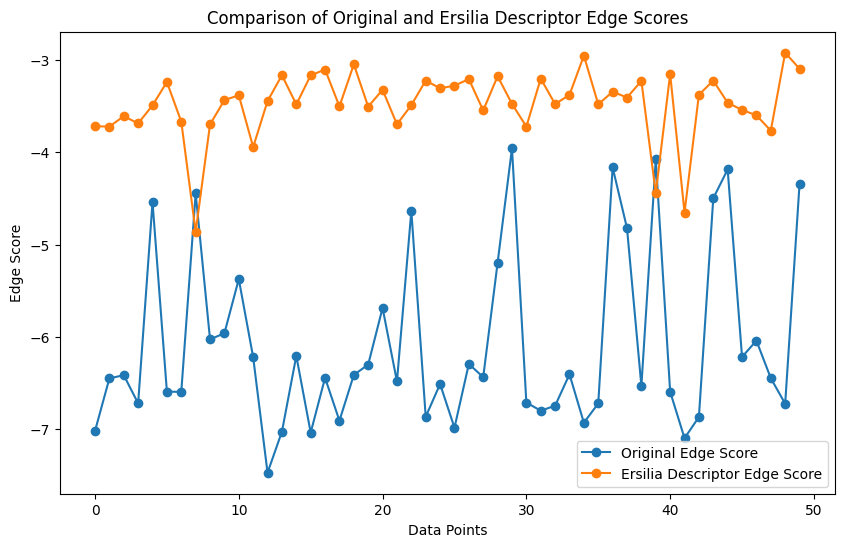

R-squared Score: -7.9064
Mean Squared Error: 7.3984


In [25]:
# Calculate R-squared score
r2 = r2_score(original_edge_score, ersilia_edge_score)

# Calculate Mean Squared Error
mse = mean_squared_error(original_edge_score, ersilia_edge_score)

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(original_edge_score[:50], label='Original Edge Score', marker='o')
plt.plot(ersilia_edge_score[:50], label='Ersilia Descriptor Edge Score', marker='o')
plt.title('Comparison of Original and Ersilia Descriptor Edge Scores')
plt.xlabel('Data Points')
plt.ylabel('Edge Score')
plt.legend()
plt.show()

# Print R-squared and MSE
print(f'R-squared Score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

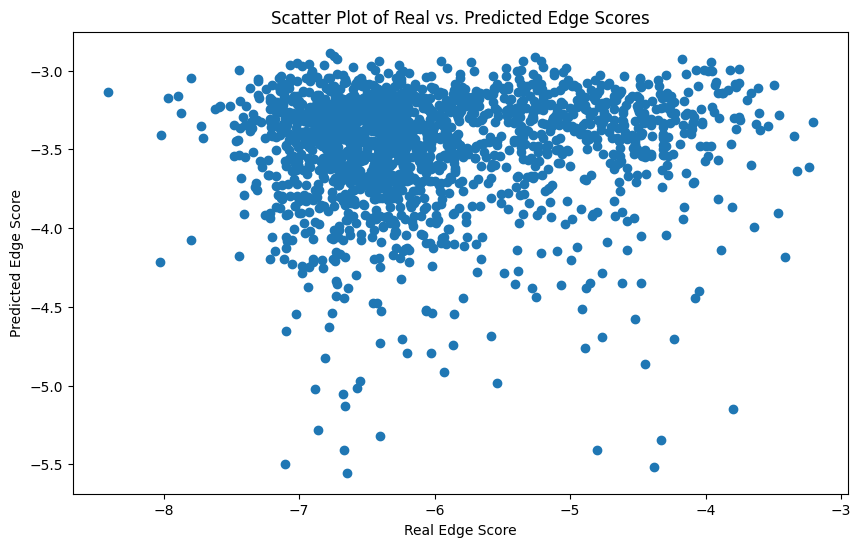

In [26]:
# Plot the scatter plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(x=original_edge_score, y=ersilia_edge_score)
plt.title('Scatter Plot of Real vs. Predicted Edge Scores')
plt.xlabel('Real Edge Score')
plt.ylabel('Predicted Edge Score')
plt.show()